# ANZ Chengdu Data Science Competition Solutions
Competition url: http://www.dcjingsai.com/common/cmpt/ANZ%20Chengdu%20Data%20Science%20Competition_%E7%AB%9E%E8%B5%9B%E4%BF%A1%E6%81%AF.html?lang=en_US
#### The challenge: predict (using provided datasets) whether the client will subscribe to a term deposit. 
#### The model metric we choose AUC
## Steps taken in this Notebook:
### 1. Data Wrangling
####     Loading the datasets
####     Visualizing data
####     Checking correlation between label and individual factors
### 2. Baseline Model
####     Code categorical features
####     Define 5-flods cross-validation function
####     Several base models
### 3. Feature Engineering
####     One-hot to categorical features
####     Some features
### 4. Xgboost & Lightgbm model

In [1]:
# checking the version of python:
!python --version

Python 3.5.4 :: Anaconda custom (32-bit)


In [2]:
# Import libraries
import pandas as pd
import numpy as np
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# machine learning models
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
seed=2018
np.random.seed(seed)

C:\Users\shaowu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Data Wrangling
#### Loading the dataset and checking its informations

In [3]:
#Exploratory Data Analysis
# load data and check it's information
data=pd.read_csv('bank-additional-train.csv',encoding='utf8')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37069 entries, 0 to 37068
Data columns (total 21 columns):
age               37069 non-null int64
job               37069 non-null object
marital           37069 non-null object
education         37069 non-null object
default           37069 non-null object
housing           37069 non-null object
loan              37069 non-null object
contact           37069 non-null object
month             37069 non-null object
day_of_week       37069 non-null object
duration          37069 non-null int64
campaign          37069 non-null int64
pdays             37069 non-null int64
previous          37069 non-null int64
poutcome          37069 non-null object
emp.var.rate      37069 non-null float64
cons.price.idx    37069 non-null float64
cons.conf.idx     37069 non-null float64
euribor3m         37069 non-null float64
nr.employed       37069 non-null float64
y                 37069 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

#### To check the first 5 rows of the dataset and the distribution of y

In [4]:
print(data.head(5))
print('--'*30)
print('Distribution of positive and negative samples:\n',data.y.value_counts())

   age         job   marital            education  default  housing     loan  \
0   32  management   married  professional.course  unknown       no       no   
1   41      admin.   married          high.school       no      yes      yes   
2   32      admin.   married    university.degree       no      yes       no   
3   37      admin.   married          high.school       no  unknown  unknown   
4   38      admin.  divorced    university.degree       no       no       no   

    contact month day_of_week ...  campaign  pdays  previous     poutcome  \
0  cellular   jul         mon ...         4    999         0  nonexistent   
1  cellular   apr         mon ...         1    999         0  nonexistent   
2  cellular   may         mon ...         2    999         0  nonexistent   
3  cellular   jul         thu ...         3    999         0  nonexistent   
4  cellular   jul         tue ...         8    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m

#### The unique value number for each column:

In [5]:
print('the unique value number for each column:\n',data.nunique())

the unique value number for each column:
 age                 77
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1514
campaign            42
pdays               26
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          315
nr.employed         11
y                    2
dtype: int64


In [6]:
print('The age range is:\n%d to %d'%(data['age'].min(),data['age'].max()))
#print('-'*40)
#print(data['emp.var.rate'].value_counts())
#print('-'*40)
#print(data['cons.conf.idx'].value_counts())

The age range is:
17 to 98


In [7]:
data['y']=data['y'].apply(lambda x:1 if x=='yes' else 0)
#data[['age','y']].groupby(['age'],as_index=False).agg({'y':'mean'}).sort_index(by='y',ascending=False)
data[['age','y']].groupby(['age'],as_index=False).mean().sort_index(by='y', ascending=False)

,age,y
76,98,1.000000
72,89,1.000000
70,87,1.000000
74,92,0.750000
60,77,0.722222
65,82,0.625000
69,86,0.600000
61,78,0.560000
63,80,0.555556
48,65,0.550000


In [8]:
#data[['job','y']].groupby(['job'],as_index=False).mean().sort_index(by='y', ascending=False)
data[['job','y']].groupby(['job'],as_index=False)['y'].agg({'num_of_samples':'count',
                                                       'y':'mean',
                                                      }).sort_index(by='y',ascending=False)

,job,y,num_of_samples
8,student,0.316195,778
5,retired,0.257161,1536
10,unemployed,0.136865,906
0,admin.,0.130171,9380
11,unknown,0.121622,296
4,management,0.111111,2646
9,technician,0.106173,6075
3,housemaid,0.101344,967
6,self-employed,0.100313,1276
2,entrepreneur,0.087547,1325


In [9]:
data[['marital','y']].groupby(['marital'],as_index=False)['y'].agg({'num_of_samples':'count',
                                                       'y':'mean',
                                                      }).sort_index(by='y',ascending=False)

,marital,y,num_of_samples
3,unknown,0.162162,74
2,single,0.139866,10410
0,divorced,0.103631,4159
1,married,0.100865,22426


In [10]:

data[['education','y']].groupby(['education'],as_index=False)['y'].agg({'num_of_samples':'count',
                                                       'y':'mean',
                                                      }).sort_index(by='y',ascending=False)

,education,y,num_of_samples
4,illiterate,0.250000,16
7,unknown,0.150738,1559
6,university.degree,0.135944,10931
5,professional.course,0.114037,4709
3,high.school,0.106371,8555
0,basic.4y,0.100528,3790
1,basic.6y,0.083495,2060
2,basic.9y,0.080015,5449


In [11]:
data[['day_of_week','y']].groupby(['day_of_week'],as_index=False)['y'].agg({'num_of_samples':'count',
                                                       'y':'mean',
                                                      }).sort_index(by='y',ascending=False)

,day_of_week,y,num_of_samples
2,thu,0.120794,7757
3,tue,0.118035,7269
4,wed,0.115395,7340
0,fri,0.106970,7030
1,mon,0.099961,7673


In [12]:
data[['month','y']].groupby(['month'],as_index=False)['y'].agg({'num_of_samples':'count',
                                                       'y':'mean',
                                                      }).sort_index(by='y',ascending=False)

,month,y,num_of_samples
5,mar,0.513026,499
2,dec,0.478261,161
8,oct,0.444620,632
9,sep,0.440079,509
0,apr,0.201765,2379
1,aug,0.105452,5576
7,nov,0.103215,3701
4,jun,0.102987,4787
3,jul,0.090053,6474
6,may,0.064529,12351


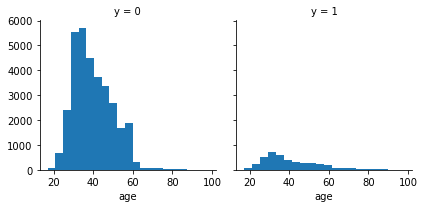

In [13]:
#Age distribution with label，then divide the age into three groups as a new featuer.
g = sns.FacetGrid(data, col='y')
g.map(plt.hist, 'age', bins=20)
data['age_group']=data['age'].apply(lambda x:1 if x<=20 else 3 if x>60 else 2)
#data['age_group'].value_counts()

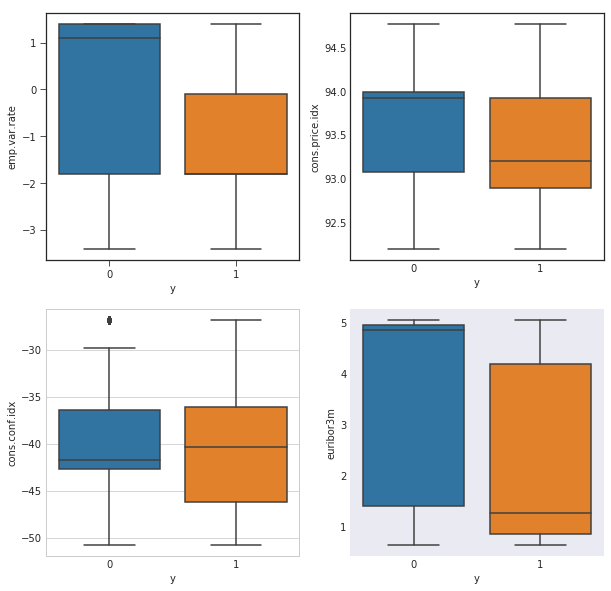

In [14]:
# Box graph, which mainly contains six data nodes, arranges a group of data from big to small,
# calculates the upper edge, the upper quartile Q3, the median, the lower quartile Q1,
# the lower edge and the outliers respectively.
var = ['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m']
axes_style = ['ticks','white','whitegrid', 'dark']

fig = plt.figure(1,figsize=(10,10))

for i in range(4):
    with sns.axes_style(axes_style[i]): 
        plt.subplot(2,2,i+1)
        sns.boxplot(x='y',y=var[i],data=data)

plt.show()


## 2. Baseline Model

In [15]:
#code categorical data
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
object_cols=[]
for col in data.columns:
    if data[col].dtype =='object':
        data[col+'_code'] = label.fit_transform(data[col])
        data.drop([col],axis=1,inplace=True)
        object_cols.append(col)

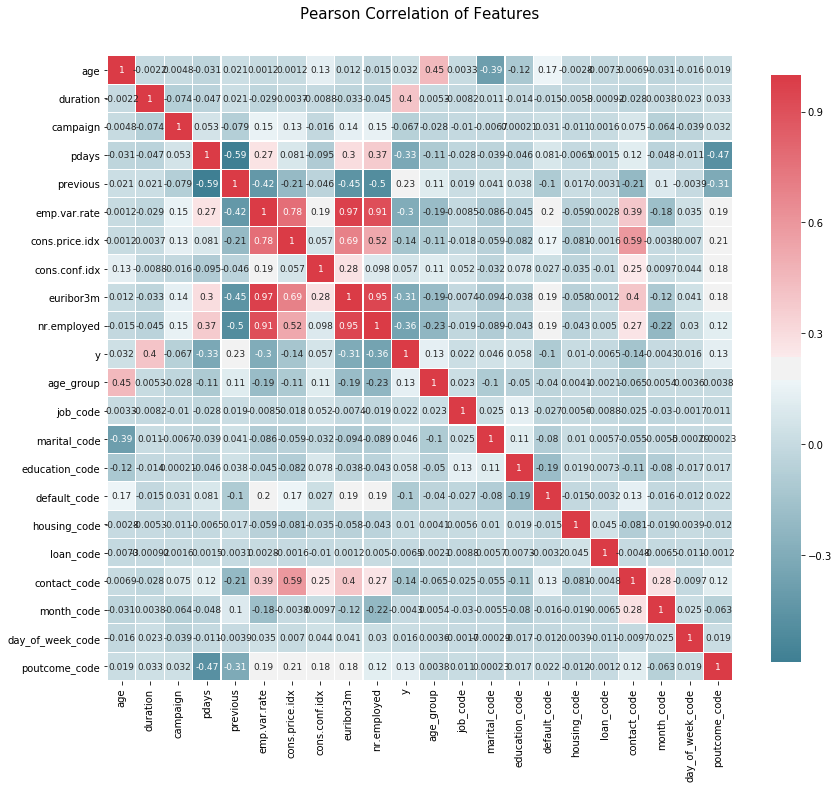

In [16]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.2,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':9 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data)

In [17]:
# define n_flod  function:
from sklearn.model_selection import KFold
def base_model(model,train,y,cv=5,random_state=42):
    N=cv
    kf = KFold(n_splits=N,shuffle=True,random_state=random_state)
    pred_list = []
    kf = kf.split(train)
    for i ,(train_fold,test_fold) in enumerate(kf):
        print('%d/%d flod training...'%(i+1,N))
        X_train, X_validate, label_train, label_validate = train.ix[train_fold, :], train.ix[test_fold, :],\
                                                       y[train_fold], y[test_fold]
        model.fit(X_train, label_train)
        y_pre=model.predict(X_validate)
        pred_list.append(roc_auc_score(label_validate,y_pre))
    return pred_list

In [18]:
# Preparing training data：
y=data['y']
train=data.drop(['y'],axis=1)

In [19]:
print('\nlr model training:')
lr = LogisticRegression()
lr_pred =base_model(lr,train,y,cv=5,random_state=42)
print('The roc_auc_score to per fold:',lr_pred)
print('The mean of roc_auc_score:',np.mean(lr_pred))

print('\nknn model training:')
knn = KNeighborsClassifier(n_neighbors = 5)
knn_pred =base_model(knn,train,y,cv=5,random_state=42)
print('The roc_auc_score to per fold:',knn_pred)
print('The mean of roc_auc_score:',np.mean(knn_pred))

# Stochastic Gradient Descent
print('\nsgd model training:')
sgd = SGDClassifier(random_state=1)
sgd_pred =base_model(sgd,train,y,cv=5,random_state=42)
print('The roc_auc_score to per fold:',sgd_pred)
print('The mean of roc_auc_score:',np.mean(sgd_pred))

# Decision Tree
print('\ndtr model training:')
dtr = DecisionTreeClassifier(random_state=1)
dtr_pred =base_model(dtr,train,y,cv=5,random_state=42)
print('The roc_auc_score to per fold:',dtr_pred)
print('The mean of roc_auc_score:',np.mean(dtr_pred))

# Random Forest
print('\nrf model training:')
rf = RandomForestClassifier(random_state=1)
rf_pred =base_model(rf,train,y,cv=5,random_state=42)
print('The roc_auc_score to per fold:',rf_pred)
print('The mean of roc_auc_score:',np.mean(rf_pred))

print('\ngbc model training:')
gbc = GradientBoostingClassifier(random_state=1)
gbc_pred =base_model(gbc,train,y,cv=5,random_state=42)
print('The roc_auc_score to per fold:',gbc_pred)
print('The mean of roc_auc_score:',np.mean(gbc_pred))

print('\netc model training:')
etc = ExtraTreesClassifier(random_state=1)
etc_pred =base_model(etc,train,y,cv=5,random_state=42)
print('The roc_auc_score to per fold:',etc_pred)
print('The mean of roc_auc_score:',np.mean(etc_pred))

print('\nridge model training:')
ridge = RidgeClassifier(random_state=1)
ridge_pred =base_model(ridge,train,y,cv=5,random_state=42)
print('The roc_auc_score to per fold:',ridge_pred)
print('The mean of roc_auc_score:',np.mean(ridge_pred))


lr model training:
1/5 flod training...
2/5 flod training...
3/5 flod training...
4/5 flod training...
5/5 flod training...
The roc_auc_score to per fold: [0.68893300970731364, 0.68813198942186926, 0.69999247243764351, 0.67577622656692227, 0.67847487250271132]
The mean of roc_auc_score: 0.686261714127

knn model training:
1/5 flod training...
2/5 flod training...
3/5 flod training...
4/5 flod training...
5/5 flod training...
The roc_auc_score to per fold: [0.72662055069236298, 0.70264965962631376, 0.72514200488348379, 0.72355579361076017, 0.71190174866228695]
The mean of roc_auc_score: 0.717973951495

sgd model training:
1/5 flod training...
2/5 flod training...
3/5 flod training...
4/5 flod training...
5/5 flod training...
The roc_auc_score to per fold: [0.67391230996507001, 0.76808338446746394, 0.59767759574997037, 0.7504769289645965, 0.6581151912235258]
The mean of roc_auc_score: 0.689653082074

dtr model training:
1/5 flod training...
2/5 flod training...
3/5 flod training...
4/5 

In [20]:
#define first xgb model
def xgb_model(X_train,y_train,X_test,y_test):
    dtrain=xgb.DMatrix(X_train,y_train)
    dval=xgb.DMatrix(X_test,y_test)
    num_rounds=50000  # Number of iterations
    params={'booster':'gbtree',
            'eta':0.1, # learning rate
            'max_depth':5, # Maximum depth of tree
            'objective':'binary:logistic',
            'eval_metric': 'auc',# 'logloss',
            #'lambda':5,
            #'alpha':8,
            'random_seed':2018
            }
    watchlist = [(dtrain,'train'),(dval,'val')]
    # model training：
    model=xgb.train(params,dtrain,num_rounds,watchlist,verbose_eval=100,early_stopping_rounds=100)
    return model

In [21]:
from sklearn.model_selection import KFold
N=5
kf = KFold(n_splits=N,shuffle=True,random_state=42)
xgb_pred = []
kf = kf.split(train)
for i ,(train_fold,test_fold) in enumerate(kf):
    print('%d/%d flod training...'%(i+1,N))
    X_train, X_validate, label_train, label_validate = train.ix[train_fold, :], train.ix[test_fold, :],\
                                                       y[train_fold], y[test_fold]
    model=xgb_model(X_train, label_train,X_validate,label_validate)
    y_pre=model.predict(xgb.DMatrix(X_validate))
    xgb_pred.append(roc_auc_score(label_validate,y_pre))
print('The roc_auc_score to per fold:',xgb_pred)
print('The mean of roc_auc_score:',np.mean(xgb_pred))

1/5 flod training...
[0]	train-auc:0.930896	val-auc:0.927838
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[100]	train-auc:0.961681	val-auc:0.949549
Stopping. Best iteration:
[66]	train-auc:0.958327	val-auc:0.949855

2/5 flod training...
[0]	train-auc:0.930559	val-auc:0.919464
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[100]	train-auc:0.96303	val-auc:0.947389
[200]	train-auc:0.971545	val-auc:0.947932
Stopping. Best iteration:
[186]	train-auc:0.970613	val-auc:0.948021

3/5 flod training...
[0]	train-auc:0.922239	val-auc:0.923963
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[100]	train-auc:0.961264	val-auc:0.954529
Stopping. Best iteration:
[71]	train-auc:0.958423	val-auc:0.954745

4/5 flod training...
[0]	

In [22]:
models=pd.DataFrame(['lr','knn','sgd','dtr','rf','gbc','etc','ridge','xgb'],columns=['models'])
kflod_AUC = pd.DataFrame([lr_pred,knn_pred,sgd_pred,
              dtr_pred,rf_pred,gbc_pred,
              etc_pred,ridge_pred,xgb_pred],columns=['{}-flod'.format(i) for i in range(1,6)])
kflod_AUC['mean_AUC']=kflod_AUC.mean(axis=1)
models=pd.concat([models,kflod_AUC],axis=1)
models.sort_index(by='mean_AUC',ascending=False).reset_index(drop=True)

,models,1-flod,2-flod,3-flod,4-flod,5-flod,mean_AUC
0,xgb,0.949287,0.947716,0.954438,0.945164,0.949188,0.949159
1,gbc,0.745979,0.732249,0.748818,0.759445,0.731094,0.743517
2,dtr,0.722483,0.736877,0.719790,0.724051,0.733132,0.727266
3,knn,0.726621,0.702650,0.725142,0.723556,0.711902,0.717974
4,rf,0.718581,0.695324,0.718758,0.700782,0.705406,0.707770
5,sgd,0.673912,0.768083,0.597678,0.750477,0.658115,0.689653
6,lr,0.688933,0.688132,0.699992,0.675776,0.678475,0.686262
7,etc,0.679633,0.668817,0.681346,0.674424,0.662267,0.673297
8,ridge,0.653557,0.641810,0.658042,0.647472,0.641163,0.648409


## 3. Feature Engineering

In [23]:
# look for categorical features and taking one-hot
one_hot_cols=[ i for i in list(train.columns) if '_code'==i[-5:]]
print('The list of columns needing to one-hot:',one_hot_cols)
new_train=train.copy()
for col in one_hot_cols:
    new_train=pd.concat([pd.get_dummies(new_train[col],prefix=col),\
              new_train],axis=1)
print('The shape of train:',train.shape)
print('The shape of new_train:',new_train.shape)

The list of columns needing to one-hot: ['job_code', 'marital_code', 'education_code', 'default_code', 'housing_code', 'loan_code', 'contact_code', 'month_code', 'day_of_week_code', 'poutcome_code']
The shape of train: (37069, 21)
The shape of new_train: (37069, 74)


In [24]:
# Some Features:
new_train['y']=y
for col in one_hot_cols+['age_group']:
    new_train=pd.merge(new_train,new_train.groupby([col],as_index=False)['y'].agg({col+'_mean': 'mean',\
                                                                                  col+'_sum':'sum',
                                                                                  }),\
                      how='left',on=[col])
print('The shape of new_train:',new_train.shape)

The shape of new_train: (37069, 97)


##  4. Xgboost & Lightgbm model

In [25]:
#define second xgb model
def xgb_model(X_train,y_train,X_test,y_test):
    dtrain=xgb.DMatrix(X_train,y_train)
    dval=xgb.DMatrix(X_test,y_test)
    num_rounds=50000  # Number of iterations
    params={'booster':'gbtree',
            'eta':0.1, # learning rate
            'max_depth':4, # Maximum depth of tree
            'objective':'binary:logistic',
            'eval_metric': 'auc',# 'logloss',
        #    'subsample':0.9,
        #    'colsample_bytree':0.9,
            'random_seed':2018
            }
    watchlist = [(dtrain,'train'),(dval,'val')]
    # model training：
    model=xgb.train(params,dtrain,num_rounds,watchlist,verbose_eval=100,early_stopping_rounds=100)
    return model

y=new_train['y']
new_train.drop(['y'],axis=1,inplace=True)
from sklearn.model_selection import KFold
N=5
kf = KFold(n_splits=N,shuffle=True,random_state=42)
new_xgb_pred = []
kf = kf.split(new_train)
for i ,(train_fold,test_fold) in enumerate(kf):
    print('%d/%d flod training...'%(i+1,N))
    X_train, X_validate, label_train, label_validate = new_train.ix[train_fold, :], new_train.ix[test_fold, :],\
                                                       y[train_fold], y[test_fold]
    model=xgb_model(X_train, label_train,X_validate,label_validate)
    y_pre=model.predict(xgb.DMatrix(X_validate))
    new_xgb_pred.append(roc_auc_score(label_validate,y_pre))
print('The roc_auc_score to per fold:',new_xgb_pred)
print('The mean of roc_auc_score:',np.mean(new_xgb_pred))

1/5 flod training...
[0]	train-auc:0.910565	val-auc:0.9163
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[100]	train-auc:0.956715	val-auc:0.950415
[200]	train-auc:0.963225	val-auc:0.950547
Stopping. Best iteration:
[140]	train-auc:0.959538	val-auc:0.950665

2/5 flod training...
[0]	train-auc:0.912481	val-auc:0.904255
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[100]	train-auc:0.957697	val-auc:0.946202
[200]	train-auc:0.963929	val-auc:0.947346
[300]	train-auc:0.968796	val-auc:0.947682
Stopping. Best iteration:
[252]	train-auc:0.966675	val-auc:0.947827

3/5 flod training...
[0]	train-auc:0.899341	val-auc:0.906266
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100 rounds.
[100]	train-auc:0.956442	val-auc:0.95393
[200]	trai